In [100]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
with open('names.txt') as f:
    words = f.read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(stoi)
print(vocab_size)

27


In [102]:
block_size = 3

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [103]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) /(n_embd*block_size)**0.5 #0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


tensor(-0.0091) tensor(0.9932)
tensor(-0.0007) tensor(0.9744)


(array([7.12254085e-05, 2.37418028e-05, 4.74836056e-05, 1.89934423e-04,
        1.42450817e-04, 2.37418028e-04, 4.74836056e-04, 8.78446704e-04,
        1.30579916e-03, 2.25547127e-03, 3.89365566e-03, 6.62396299e-03,
        1.07550367e-02, 1.49335940e-02, 2.42641225e-02, 3.55414788e-02,
        5.44636957e-02, 7.64723469e-02, 1.08927391e-01, 1.55152681e-01,
        2.04250730e-01, 2.61207315e-01, 3.30224735e-01, 3.77470923e-01,
        4.32480680e-01, 4.36920397e-01, 4.30866238e-01, 3.99218414e-01,
        3.38914235e-01, 2.80794302e-01, 2.11966816e-01, 1.65385398e-01,
        1.22578928e-01, 8.56129410e-02, 5.97581177e-02, 4.05747410e-02,
        2.66620446e-02, 1.77826103e-02, 1.04463932e-02, 7.40744248e-03,
        4.22604090e-03, 2.56411470e-03, 1.70940980e-03, 1.16334834e-03,
        7.35995887e-04, 4.27352451e-04, 9.49672113e-05, 1.42450817e-04,
        4.74836056e-05, 7.12254085e-05]),
 array([-5.39786959, -5.18727058, -4.97667158, -4.76607258, -4.55547358,
        -4.34487457, 

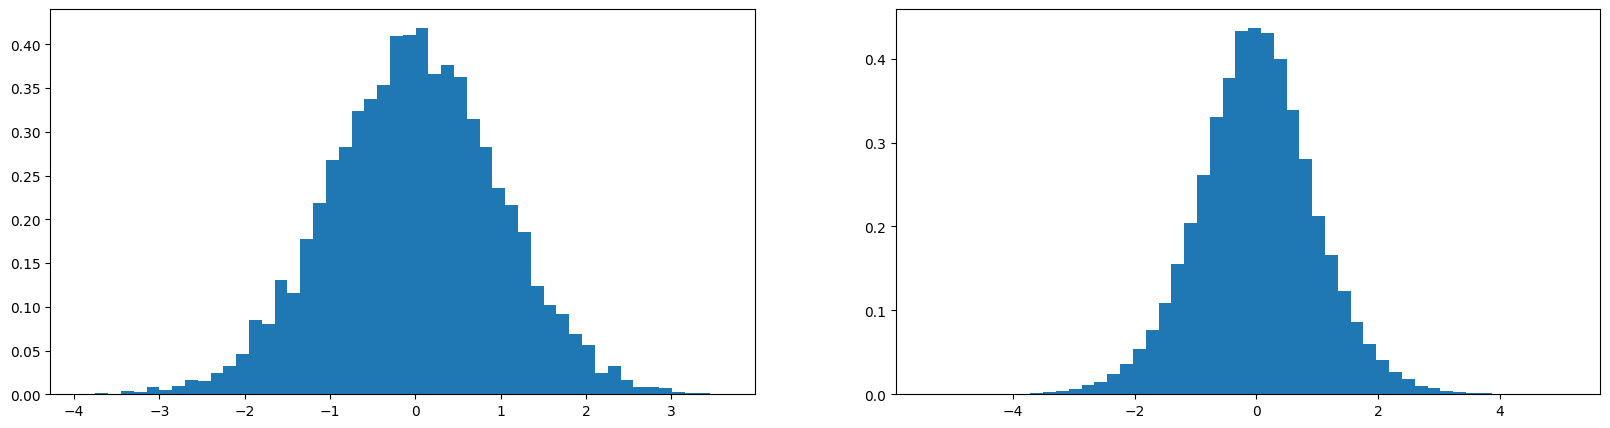

In [104]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

In [105]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.size(0), (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.2931
  10000/ 200000: 2.2054
  20000/ 200000: 2.1349
  30000/ 200000: 2.2107
  40000/ 200000: 2.1015
  50000/ 200000: 2.0310
  60000/ 200000: 1.9080
  70000/ 200000: 2.5506
  80000/ 200000: 2.1482
  90000/ 200000: 2.0106
 100000/ 200000: 2.1334
 110000/ 200000: 2.4188
 120000/ 200000: 2.0252
 130000/ 200000: 2.1637
 140000/ 200000: 2.0370
 150000/ 200000: 2.1680
 160000/ 200000: 2.4039
 170000/ 200000: 2.2611
 180000/ 200000: 1.8085
 190000/ 200000: 2.0026


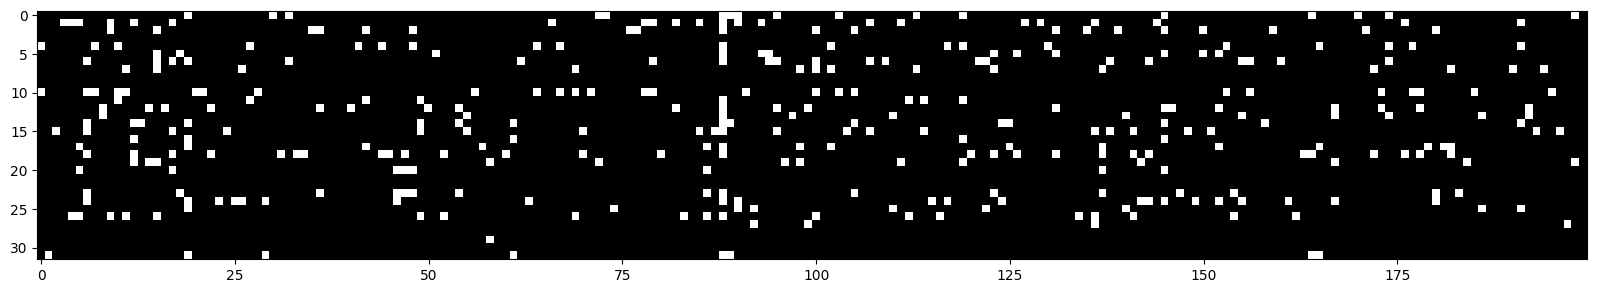

In [106]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([471., 239., 198., 140., 125., 106., 116., 111., 107.,  94.,  88.,
         91., 102.,  93., 109.,  79., 104., 133., 101., 120.,  50., 159.,
        111., 128., 121., 115., 113.,  65., 132., 102.,  81., 137., 101.,
        114.,  98.,  91.,  74.,  78., 114.,  95., 109.,  86., 109.,  89.,
        111., 124., 153., 167., 228., 418.]),
 array([-9.99990821e-01, -9.59991461e-01, -9.19992101e-01, -8.79992741e-01,
        -8.39993382e-01, -7.99994022e-01, -7.59994662e-01, -7.19995302e-01,
        -6.79995942e-01, -6.39996582e-01, -5.99997222e-01, -5.59997863e-01,
        -5.19998503e-01, -4.79999143e-01, -4.39999783e-01, -4.00000423e-01,
        -3.60001063e-01, -3.20001704e-01, -2.80002344e-01, -2.40002984e-01,
        -2.00003624e-01, -1.60004264e-01, -1.20004904e-01, -8.00055444e-02,
        -4.00061846e-02, -6.82473183e-06,  3.99925351e-02,  7.99918950e-02,
         1.19991255e-01,  1.59990615e-01,  1.99989974e-01,  2.39989334e-01,
         2.79988694e-01,  3.19988054e-01,  3.59987

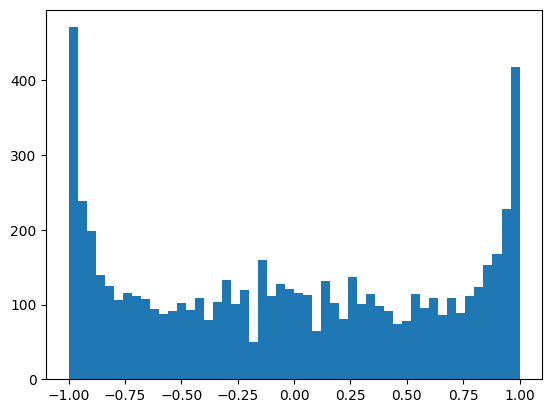

In [107]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   1.,   8.,   4.,   6.,   9.,  11.,  10.,
         25.,  31.,  35.,  61.,  73.,  98., 125., 164., 207., 218., 261.,
        344., 408., 551., 662., 591., 552., 383., 317., 250., 212., 183.,
        150., 111.,  81.,  67.,  61.,  40.,  24.,  19.,  11.,  10.,   9.,
          4.,   4.,   3.,   1.,   0.,   1.]),
 array([-6.1447506 , -5.9080579 , -5.6713652 , -5.43467251, -5.19797981,
        -4.96128712, -4.72459442, -4.48790173, -4.25120903, -4.01451633,
        -3.77782364, -3.54113094, -3.30443825, -3.06774555, -2.83105286,
        -2.59436016, -2.35766747, -2.12097477, -1.88428207, -1.64758938,
        -1.41089668, -1.17420399, -0.93751129, -0.7008186 , -0.4641259 ,
        -0.2274332 ,  0.00925949,  0.24595219,  0.48264488,  0.71933758,
         0.95603027,  1.19272297,  1.42941566,  1.66610836,  1.90280106,
         2.13949375,  2.37618645,  2.61287914,  2.84957184,  3.08626453,
         3.32295723,  3.55964993,  3.79634262,  4.03303532,  4.26972801,
 

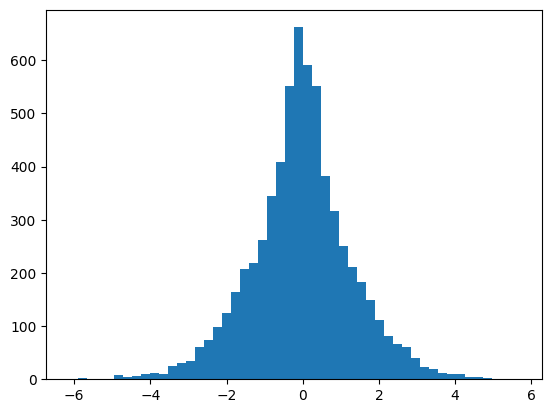

In [108]:
plt.hist(hpreact.view(-1).tolist(), 50)

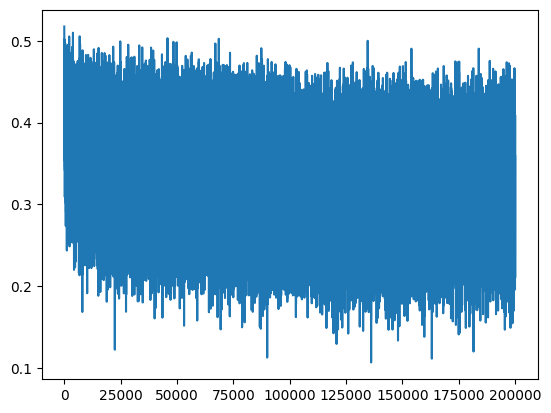

In [109]:
plt.plot(lossi)

In [110]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [112]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067242383956909
val 2.107104539871216


In [119]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):

        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(x.var + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

n_embd = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.require_grad = True

47024


In [ ]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization